In [1]:
import pandas as pd
import numpy as np
from keras import utils, models, layers
from sklearn import metrics, model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
#Run data in X
churn_df = pd.read_csv("C:/Users/Usuario/Anaconda3/Tavo/BankChurn/BankData01.csv")
y = churn_df['Exited']
X1 = pd.get_dummies(churn_df['Gender'])
X2 = churn_df[["IsActiveMember", "Age", "HasCrCard", "NumOfProducts", "Balance", "CreditScore", "Tenure", "EstimatedSalary"]]
X = pd.concat([X1, X2], axis=1)
#Use this to remove one of the dummy variables to avoid multicollinearity 
X = X[X.columns[1:]] 
#Scale variables when the algo uses encleudiean distances (e.g. Logistic Regression, K-nearest, )
escalador = StandardScaler()
X_esc = escalador.fit_transform(X)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)
X_train_esc = escalador.fit_transform(X_train)
X_test_esc = escalador.fit_transform(X_test)

# Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train_esc, y_train)
print("Logistic Regression accuracy (training set):", 
      round(model_selection.cross_val_score(logreg, X_train, y_train, scoring='accuracy',cv=50).mean(), 4))
print("Logistic Regression accuracy (test set):", 
      round(model_selection.cross_val_score(logreg, X_test, y_test, scoring='accuracy',cv=50).mean(), 4))

Logistic Regression accuracy (training set): 0.7904
Logistic Regression accuracy (test set): 0.7885


In [15]:
logreg.fit(X_esc, y)
scores = logreg.predict_proba(X_esc)[:, 1]
y_pred_logreg = (scores > 0.25).astype(int)
conf0 = metrics.confusion_matrix(y, y_pred_logreg)
print(conf0)
tp0 = conf0[1,1] / (conf0[1,1] + conf0[1,0])
fp0 = conf0[0,1] / (conf0[0,0] + conf0[0,1])
fn0 = conf0[1,0] / (conf0[1,0] + conf0[1,1])
print('True positive rate (Logistic Regression):', round(tp0,4))
print('False positive rate (Logistic Regression):', round(fp0, 4))
#False negative rate is 1 - true positive rate.

[[6222 1741]
 [ 836 1201]]
True positive rate (Logistic Regression): 0.5896
False positive rate (Logistic Regression): 0.2186


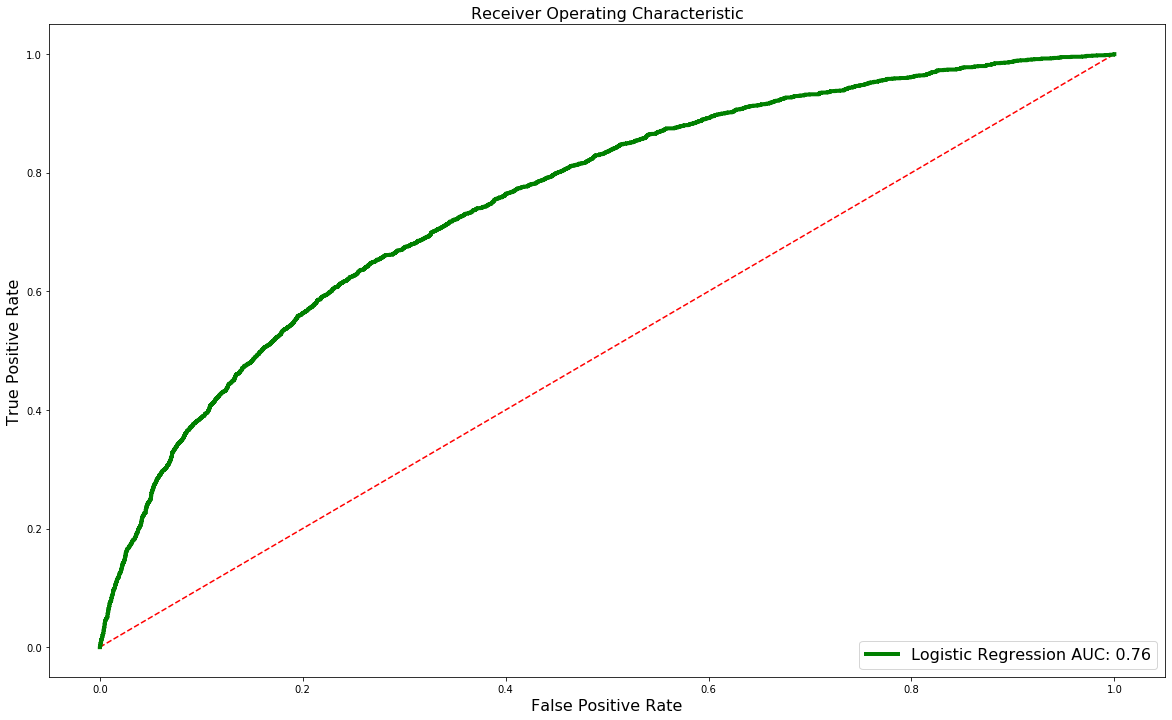

In [16]:
#code was just a copy paste from a web page
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 12))
plt.plot([0,1], [0,1], 'r--')

probs = logreg.predict_proba(X_esc)
probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y, probs)
roc_auc = auc(fpr, tpr)
label = 'Logistic Regression AUC:' + ' {0:.2f}'.format(roc_auc)
plt.plot(fpr, tpr, c = 'g', label = label, linewidth = 4)
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize = 16)
plt.title('Receiver Operating Characteristic', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

78.1541


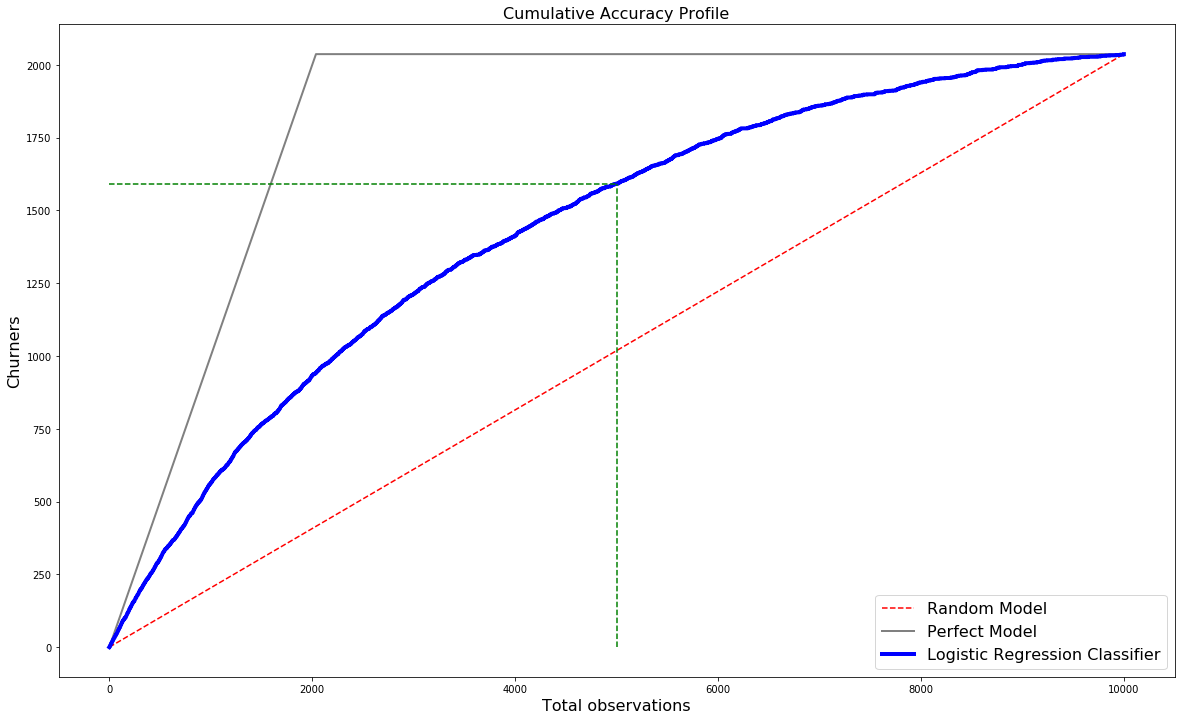

In [17]:
#code was just a copy paste
total = len(y)
class_1_count = np.sum(y)
class_0_count = total - class_1_count
plt.figure(figsize = (20, 12))
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')
probs = logreg.predict_proba(X_esc)
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, y), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'b', 
         label = 'Logistic Regression Classifier', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 16)
plt.ylabel('Churners', fontsize = 16)
plt.title('Cumulative Accuracy Profile', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)
print(round(class_1_observed, 4))

In [18]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])
# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a
# Area between Trained and Random Model
aR = auc(x_values, y_values) - a
print("Accuracy Rate for Logistic Regression: ", round(aR / aP, 4))

Accuracy Rate for Logistic Regression:  0.5111


# Random Forest Classifier

In [3]:
from sklearn.ensemble import RandomForestClassifier
#No overfitting so there is no need to divide between training and test; nevertheless, its a good practice.
#Using gini or entropy is the same
forest = RandomForestClassifier(criterion = 'entropy', n_estimators=100, max_depth=20, max_leaf_nodes=32)
forest.fit(X_train, y_train)
print("Random Forest accuracy (training set):", 
      round(model_selection.cross_val_score(forest, X_train, y_train, scoring='accuracy',cv=50).mean(), 4))
print("Random Forest accuracy (test set):", 
      round(model_selection.cross_val_score(forest, X_test, y_test, scoring='accuracy',cv=50).mean(), 4))

Random Forest accuracy (training set): 0.8569
Random Forest accuracy (test set): 0.854


In [4]:
forest.fit(X, y)
y_pred = forest.predict(X)
conf = metrics.confusion_matrix(y, y_pred)
print(conf)
tp1 = conf[1,1] / (conf[1,1] + conf[1,0])
fp1 = conf[0,1] / (conf[0,0] + conf[0,1])
fn1 = conf[1,0] / (conf[1,0] + conf[1,1])
print('True positive rate (Random Forest):', round(tp1,4))
print('False positive rate (Random Forest):', round(fp1, 4))
#False negative rate is 1 - true positive rate.

[[7781  182]
 [1233  804]]
True positive rate (Random Forest): 0.3947
False positive rate (Random Forest): 0.0229


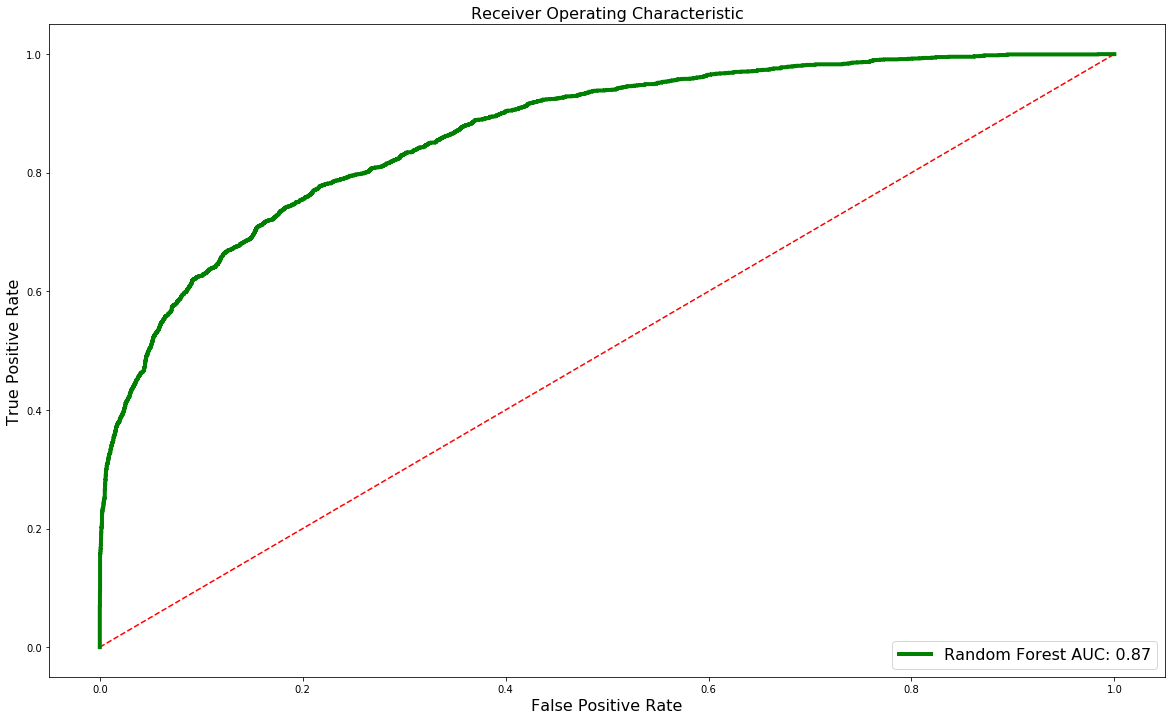

In [5]:
#code was just a copy paste from a web page
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 12))
plt.plot([0,1], [0,1], 'r--')

probs = forest.predict_proba(X)
probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y, probs)
roc_auc = auc(fpr, tpr)
label = 'Random Forest AUC:' + ' {0:.2f}'.format(roc_auc)
plt.plot(fpr, tpr, c = 'g', label = label, linewidth = 4)
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize = 16)
plt.title('Receiver Operating Characteristic', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

90.0835


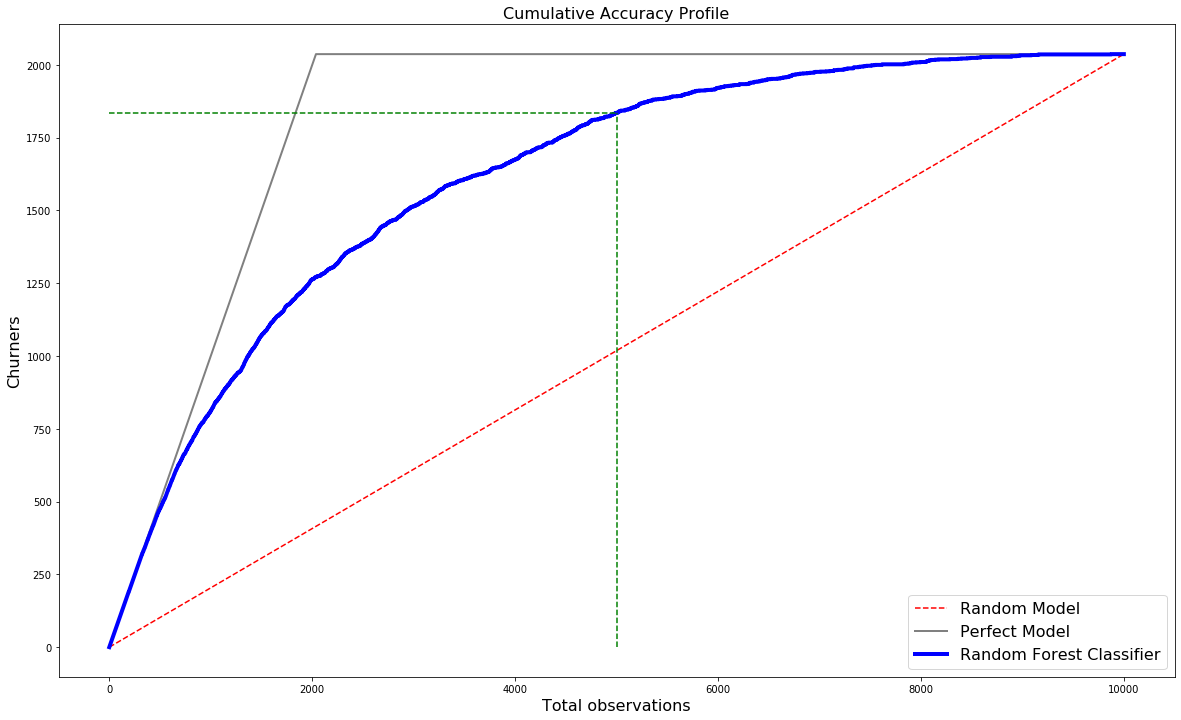

In [6]:
#code was just a copy paste
total = len(y)
class_1_count = np.sum(y)
class_0_count = total - class_1_count
plt.figure(figsize = (20, 12))
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')
probs = forest.predict_proba(X)
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, y), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'b', 
         label = 'Random Forest Classifier', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 16)
plt.ylabel('Churners', fontsize = 16)
plt.title('Cumulative Accuracy Profile', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)
print(round(class_1_observed, 4))

In [7]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])
# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a
# Area between Trained and Random Model
aR = auc(x_values, y_values) - a
print("Accuracy Rate for Random Forest: ", round(aR / aP, 4))

Accuracy Rate for Random Forest:  0.7347


# Gradient Boosting Classifier

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=4)
gbc.fit(X_train, y_train)
print('Gradient Boosting Classifier accuracy (training set):', 
      round(model_selection.cross_val_score(gbc, X_train, y_train, scoring='accuracy',cv=50).mean(), 4))
print('Gradient Boosting Classifier accuracy (test set):',
      round(model_selection.cross_val_score(gbc, X_test, y_test, scoring='accuracy',cv=50).mean(), 4))

Gradient Boosting Classifier accuracy (training set): 0.8577
Gradient Boosting Classifier accuracy (test set): 0.859


In [9]:
gbc.fit(X, y)
y_pred_gbc = gbc.predict(X)
conf2 = metrics.confusion_matrix(y, y_pred_gbc)
print(conf2)
tp2 = conf2[1,1] / (conf2[1,1] + conf2[1,0])
fp2 = conf2[0,1] / (conf2[0,0] + conf2[0,1])
print('True positive rate (Gradient Boosting Classifier):', round(tp2,4))
print('False positive rate (Gradient Boosting Classifier):', round(fp2, 4))

[[7757  206]
 [1058  979]]
True positive rate (Gradient Boosting Classifier): 0.4806
False positive rate (Gradient Boosting Classifier): 0.0259


In [10]:
#Review overfitting with escalated vars
gbc.fit(X_train_esc, y_train)
print('Gradient Boosting Classifier accuracy (training set):', 
      round(model_selection.cross_val_score(gbc, X_train_esc, y_train, scoring='accuracy',cv=50).mean(), 4))
print('Gradient Boosting Classifier accuracy (test set):',
      round(model_selection.cross_val_score(gbc, X_test_esc, y_test, scoring='accuracy',cv=50).mean(), 4))

Gradient Boosting Classifier accuracy (training set): 0.8576
Gradient Boosting Classifier accuracy (test set): 0.858


In [11]:
gbc.fit(X_esc, y)
y_pred_gbc_esc = gbc.predict(X_esc)
conf3 = metrics.confusion_matrix(y, y_pred_gbc_esc)
print(conf3)
tp3 = conf3[1,1] / (conf3[1,1] + conf3[1,0])
fp3 = conf3[0,1] / (conf3[0,0] + conf3[0,1])
print('True positive rate (Gradient Boosting Classifier escalated):', round(tp3,4))
print('False positive rate (Gradient Boosting Classifier escalated):', round(fp3, 4))

[[7757  206]
 [1058  979]]
True positive rate (Gradient Boosting Classifier escalated): 0.4806
False positive rate (Gradient Boosting Classifier escalated): 0.0259


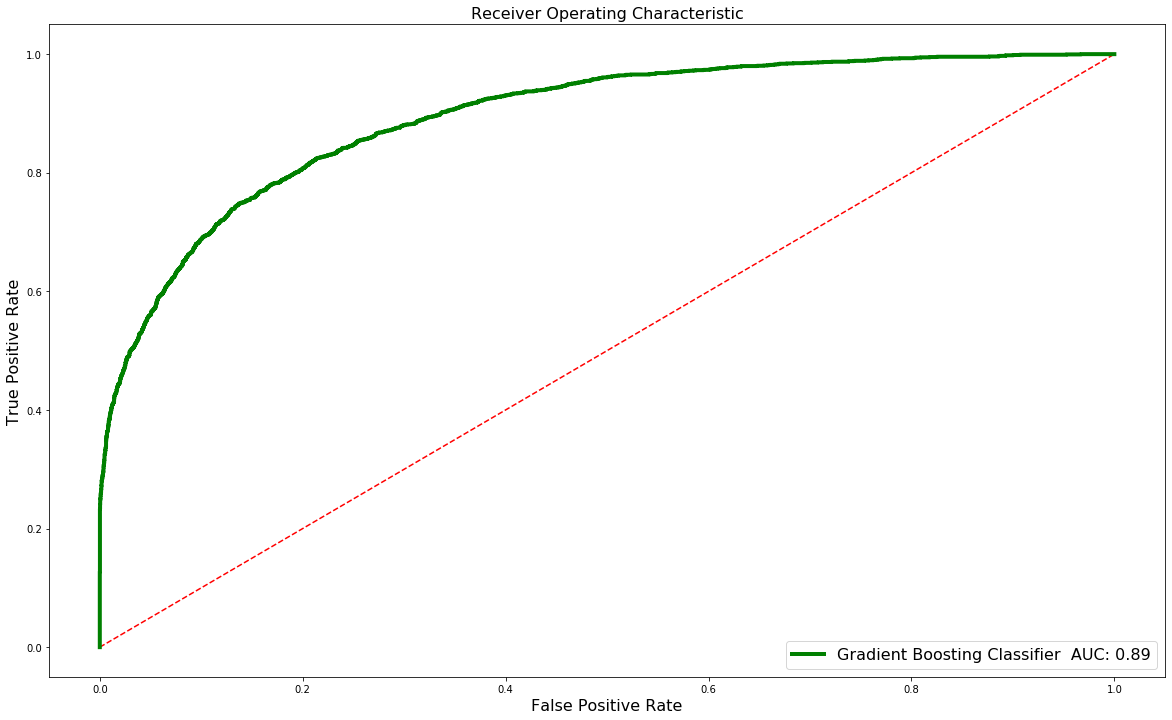

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 12))
plt.plot([0,1], [0,1], 'r--')

probs = gbc.predict_proba(X_esc)
probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y, probs)
roc_auc = auc(fpr, tpr)
label = 'Gradient Boosting Classifier  AUC:' + ' {0:.2f}'.format(roc_auc)
plt.plot(fpr, tpr, c = 'g', label = label, linewidth = 4)
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize = 16)
plt.title('Receiver Operating Characteristic', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

92.68532155130093


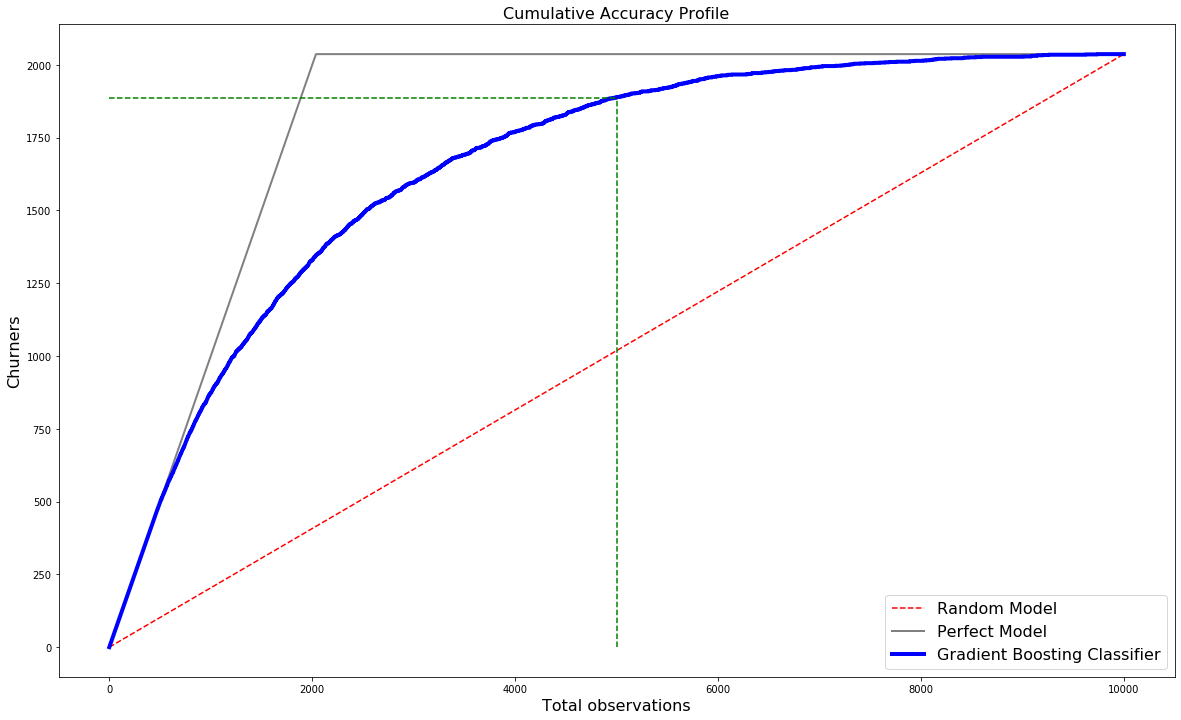

In [13]:
total = len(y)
class_1_count = np.sum(y)
class_0_count = total - class_1_count
plt.figure(figsize = (20, 12))
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')
probs = gbc.predict_proba(X_esc)
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, y), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'b', 
         label = 'Gradient Boosting Classifier', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 16)
plt.ylabel('Churners', fontsize = 16)
plt.title('Cumulative Accuracy Profile', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)
print(class_1_observed)

In [14]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])
# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a
# Area between Trained and Random Model
aR = auc(x_values, y_values) - a
print("Accuracy Rate for Random Forest: ", round(aR / aP, 4))

Accuracy Rate for Random Forest:  0.7857


# MLP Classifier

In [31]:
#My guess is that it uses euclidean differences because if not escalated the model is not ok
from sklearn import neural_network
from  warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
mlp = neural_network.MLPClassifier(hidden_layer_sizes=(32,4), max_iter=200)
mlp.fit(X_train_esc, y_train)
print('MLP Classifier accuracy (training set):', 
      round(model_selection.cross_val_score(gbc, X_train_esc, y_train, scoring='accuracy',cv=50).mean(), 4))
print('MLP Classifier accuracy (test set):', 
      round(model_selection.cross_val_score(gbc, X_test_esc, y_test, scoring='accuracy',cv=50).mean(), 4))

MLP Classifier accuracy (training set): 0.8574
MLP Classifier accuracy (test set): 0.846


In [32]:
mlp.fit(X_esc, y)
y_pred_mlpf_esc = mlp.predict(X_esc)
conf4 = metrics.confusion_matrix(y, y_pred_mlpf_esc)
print(conf4)
tp4 = conf4[1,1] / (conf4[1,1] + conf4[1,0])
fp4 = conf4[0,1] / (conf4[0,0] + conf4[0,1])
print('True positive rate (MLP Classifier):', round(tp4,4))
print('False positive rate (MLP Classifier):', round(fp4, 4))

[[7701  262]
 [1096  941]]
True positive rate (MLP Classifier): 0.462
False positive rate (MLP Classifier): 0.0329


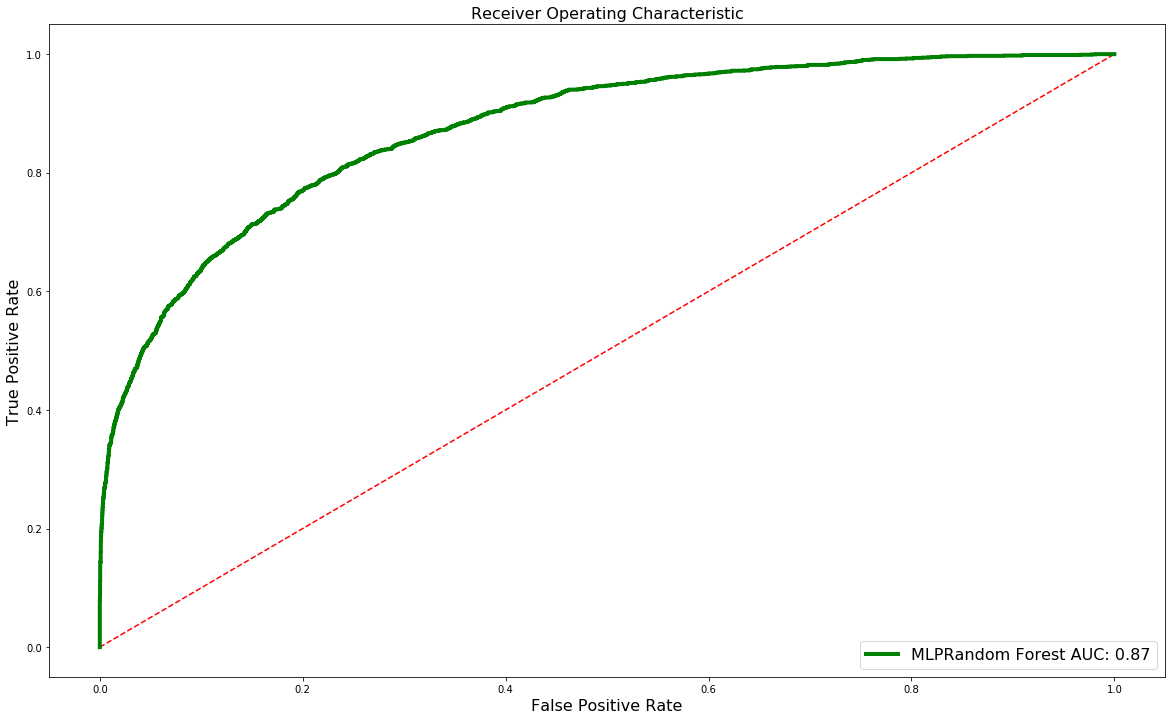

In [33]:
#code was just a copy paste from a web page
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 12))
plt.plot([0,1], [0,1], 'r--')

probs = mlp.predict_proba(X_esc)
probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y, probs)
roc_auc = auc(fpr, tpr)
label = 'MLPRandom Forest AUC:' + ' {0:.2f}'.format(roc_auc)
plt.plot(fpr, tpr, c = 'g', label = label, linewidth = 4)
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize = 16)
plt.title('Receiver Operating Characteristic', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

90.62346588119784


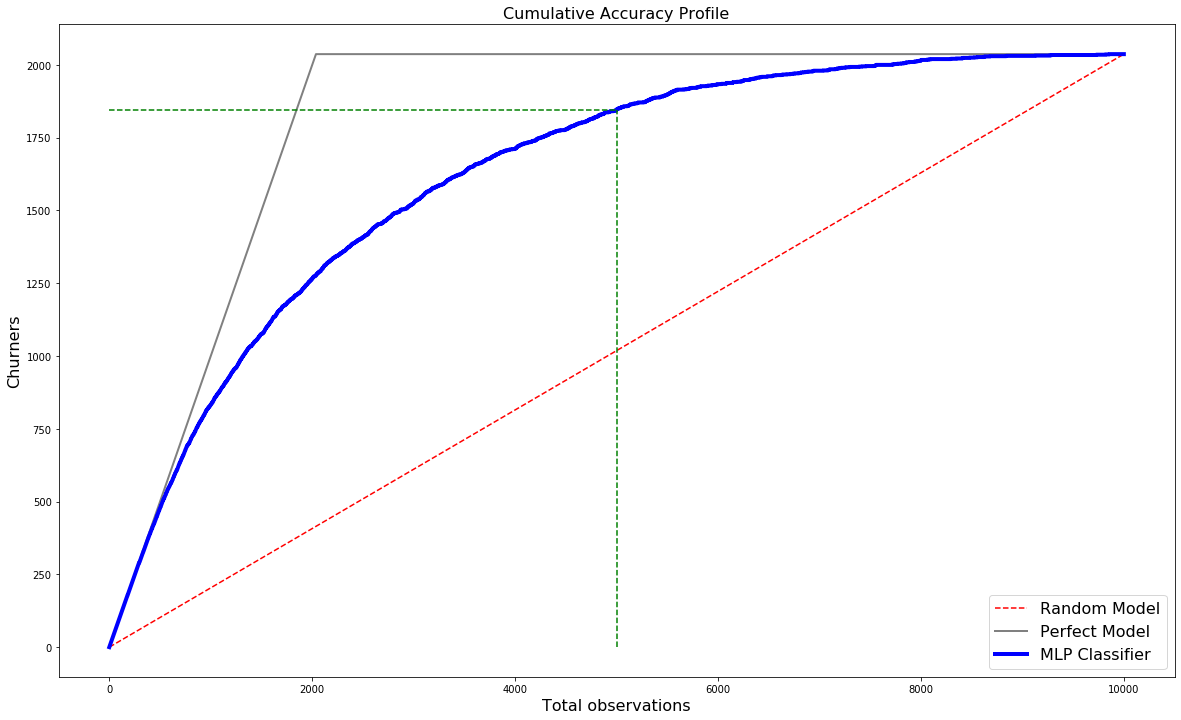

In [34]:
total = len(y)
class_1_count = np.sum(y)
class_0_count = total - class_1_count
plt.figure(figsize = (20, 12))
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')
probs = mlp.predict_proba(X_esc)
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, y), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'b', 
         label = 'MLP Classifier', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 16)
plt.ylabel('Churners', fontsize = 16)
plt.title('Cumulative Accuracy Profile', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)
print(class_1_observed)

In [35]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])
# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a
# Area between Trained and Random Model
aR = auc(x_values, y_values) - a
print("MLP: ", round(aR / aP, 4))

MLP:  0.7486


# K-neighbors 

In [36]:
from sklearn.neighbors import KNeighborsClassifier
#Review overfitting with training set and test set w data.
#Use escalated variables because it is based on encleudiean distances.
#Using 11 neighbors because 5 gives overfitting. 
knc = KNeighborsClassifier(n_neighbors = 11, metric = 'minkowski', p = 2)
knc.fit(X_train_esc, y_train)
print('K-Neighbors Classifier accuracy (training set):', 
      round(model_selection.cross_val_score(knc, X_train_esc, y_train, scoring='accuracy',cv=50).mean(), 4))
print('K-Neighbors Classifier accuracy (test set):', 
      round(model_selection.cross_val_score(knc, X_test_esc, y_test, scoring='accuracy',cv=50).mean(), 4))

K-Neighbors Classifier accuracy (training set): 0.8345
K-Neighbors Classifier accuracy (test set): 0.8185


In [37]:
knc.fit(X_esc, y)
y_pred_knc = knc.predict(X_esc)
conf5 = metrics.confusion_matrix(y, y_pred_knc)
print(conf5)
tp5 = conf5[1,1] / (conf5[1,1] + conf5[1,0])
fp5 = conf5[0,1] / (conf5[0,0] + conf5[0,1])
print('True positive rate (K-Neighbors Classifier):', round(tp5,4))
print('False positive rate (K-Neighbors Classifier):', round(fp5, 4))

[[7781  182]
 [1252  785]]
True positive rate (K-Neighbors Classifier): 0.3854
False positive rate (K-Neighbors Classifier): 0.0229


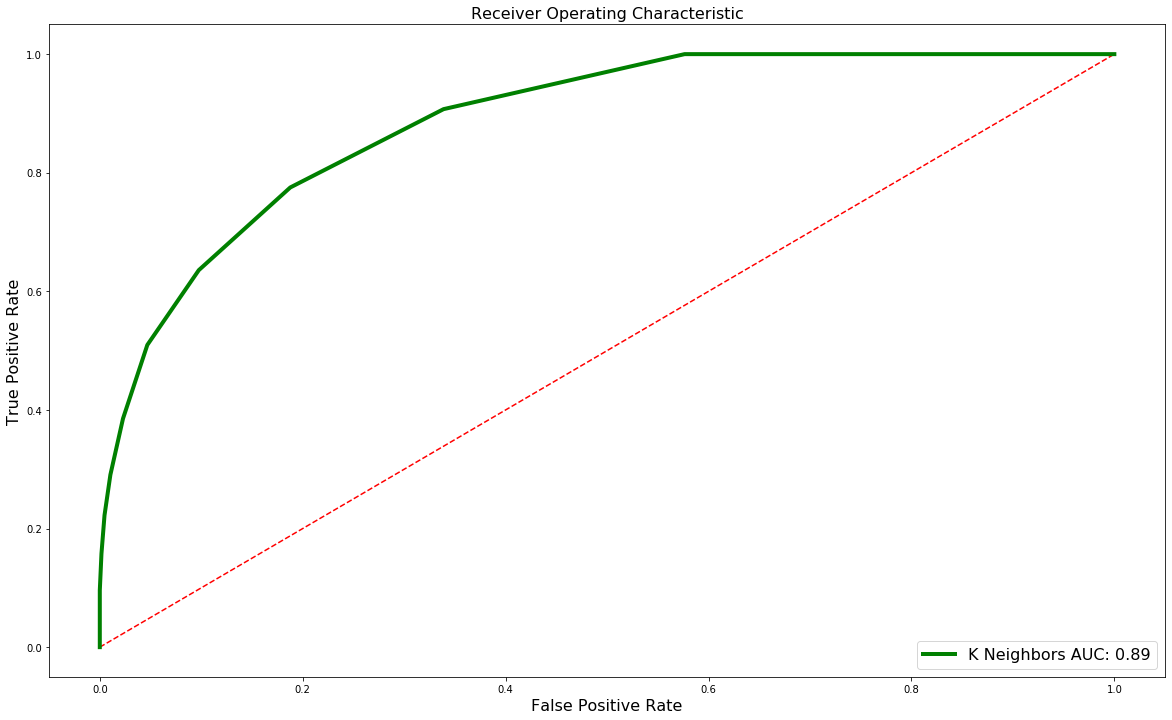

In [38]:
#code was just a copy paste from a web page
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 12))
plt.plot([0,1], [0,1], 'r--')

probs = knc.predict_proba(X_esc)
probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y, probs)
roc_auc = auc(fpr, tpr)
label = 'K Neighbors AUC:' + ' {0:.2f}'.format(roc_auc)
plt.plot(fpr, tpr, c = 'g', label = label, linewidth = 4)
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize = 16)
plt.title('Receiver Operating Characteristic', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

100.0


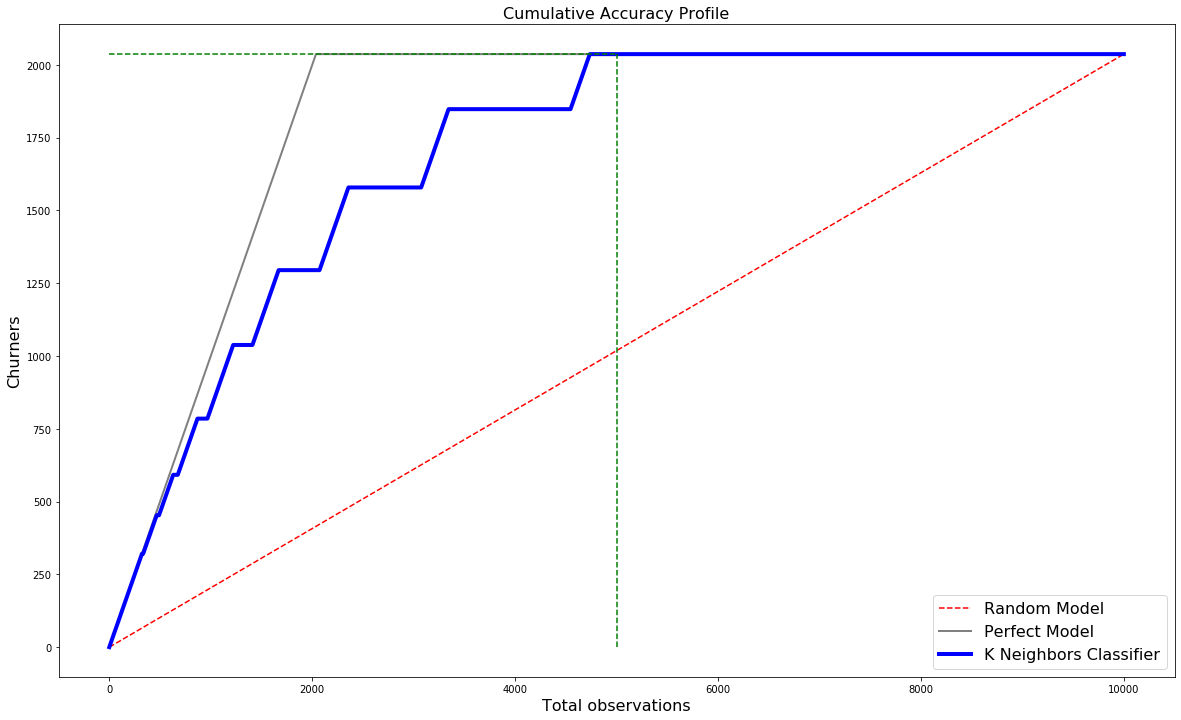

In [39]:
total = len(y)
class_1_count = np.sum(y)
class_0_count = total - class_1_count
plt.figure(figsize = (20, 12))
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')
probs = knc.predict_proba(X_esc)
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, y), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'b', 
         label = 'K Neighbors Classifier', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 16)
plt.ylabel('Churners', fontsize = 16)
plt.title('Cumulative Accuracy Profile', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)
print(class_1_observed)

In [40]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])
# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a
# Area between Trained and Random Model
aR = auc(x_values, y_values) - a
print("Accuracy Rate for K Neighbors: ", round(aR / aP, 4))

Accuracy Rate for K Neighbors:  0.84


# SVC

In [41]:
from sklearn.svm import SVC
#Escalate data and use kernel rbf (radial base function). Poly works, but not as good (lower TP). 
#Linear does not predict churn, sigmoid gives true positive of 20 and accuracy below 80. 
svc = SVC(kernel = 'rbf', probability = True)
svc.fit(X_train_esc, y_train)
print('SVC Classifier accuracy (training set):',
      round(model_selection.cross_val_score(svc, X_train_esc, y_train, scoring='accuracy',cv=50).mean(), 4))
print('SVC Classifier accuracy (test set):', 
      round(model_selection.cross_val_score(svc, X_test_esc, y_test, scoring='accuracy',cv=50).mean(), 4))

SVC Classifier accuracy (training set): 0.8535
SVC Classifier accuracy (test set): 0.847


In [42]:
svc.fit(X_esc, y)
y_pred_svc = svc.predict(X_esc)
conf6 = metrics.confusion_matrix(y, y_pred_svc)
print(conf6)
tp6 = conf6[1,1] / (conf6[1,1] + conf6[1,0])
fp6 = conf6[0,1] / (conf6[0,0] + conf6[0,1])
print('True positive rate (SVC Classifier):', round(tp6,4))
print('False positive rate (SVC Classifier):', round(fp6, 4))

[[7805  158]
 [1256  781]]
True positive rate (SVC Classifier): 0.3834
False positive rate (SVC Classifier): 0.0198


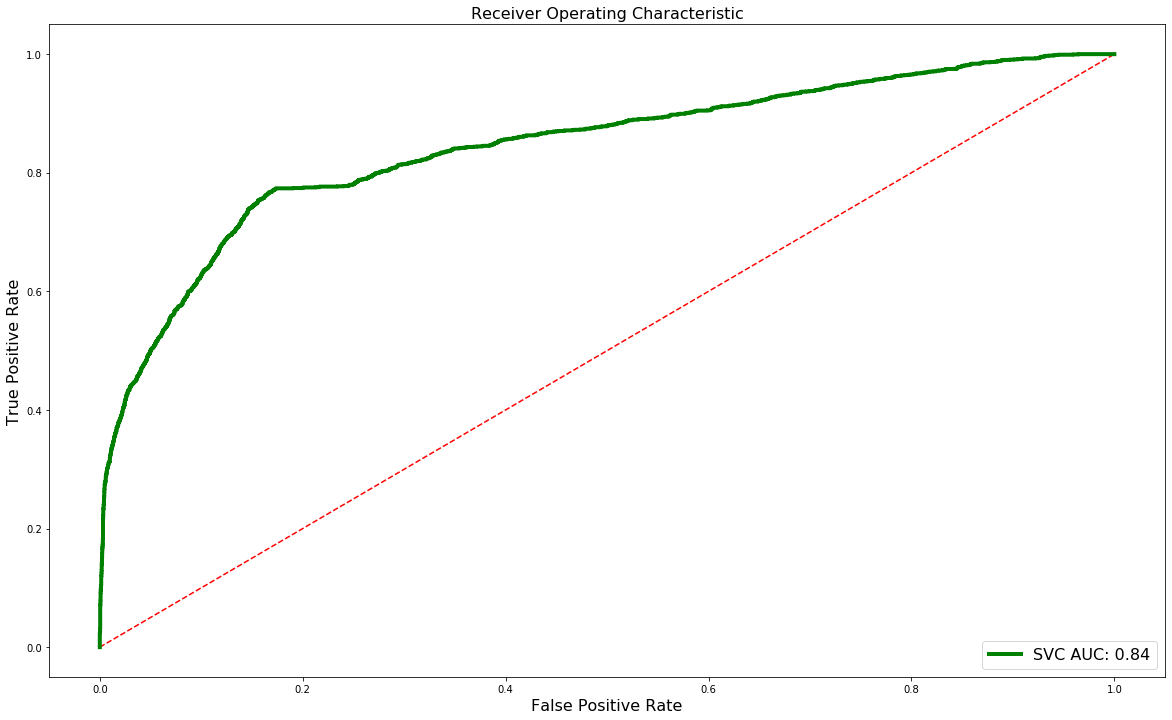

In [43]:
#code was just a copy paste from a web page
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 12))
plt.plot([0,1], [0,1], 'r--')

probs = svc.predict_proba(X_esc)
probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y, probs)
roc_auc = auc(fpr, tpr)
label = 'SVC AUC:' + ' {0:.2f}'.format(roc_auc)
plt.plot(fpr, tpr, c = 'g', label = label, linewidth = 4)
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize = 16)
plt.title('Receiver Operating Characteristic', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

85.86156111929307


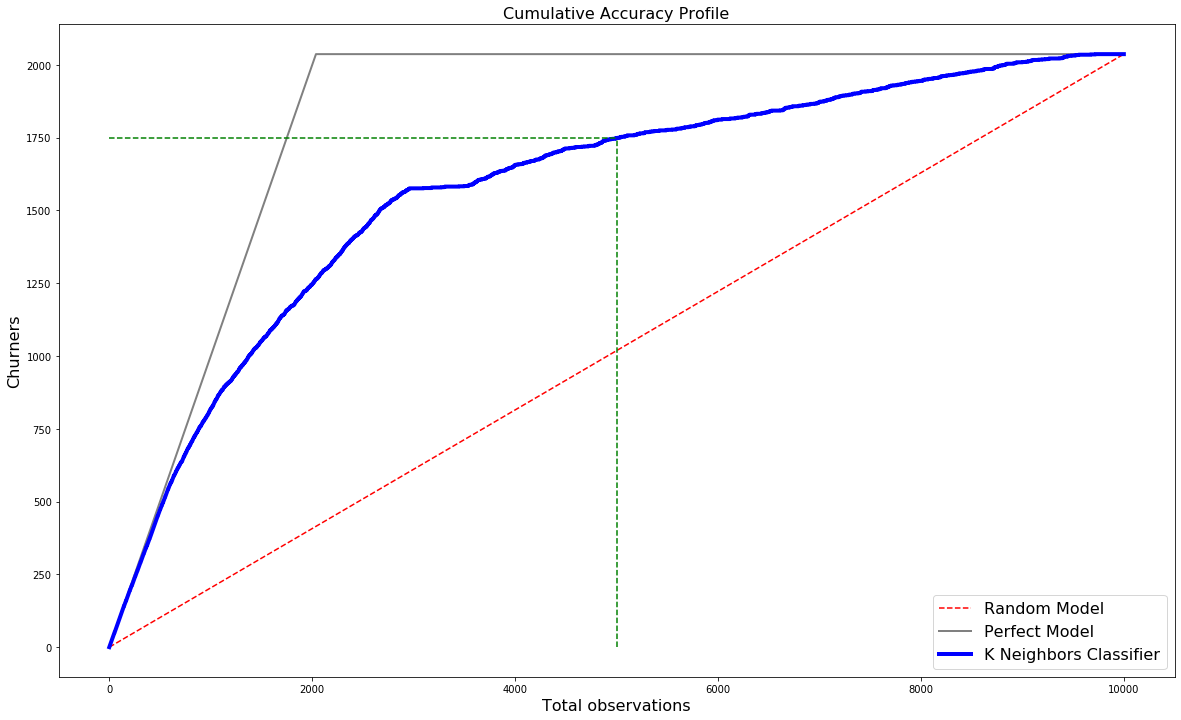

In [44]:
total = len(y)
class_1_count = np.sum(y)
class_0_count = total - class_1_count
plt.figure(figsize = (20, 12))
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')
probs = svc.predict_proba(X_esc)
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, y), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'b', 
         label = 'K Neighbors Classifier', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 16)
plt.ylabel('Churners', fontsize = 16)
plt.title('Cumulative Accuracy Profile', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)
print(class_1_observed)

In [45]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])
# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a
# Area between Trained and Random Model
aR = auc(x_values, y_values) - a
print("Accuracy Rate for SVC: ", round(aR / aP, 4))

Accuracy Rate for SVC:  0.6877


# Naive Bayes

In [46]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_esc, y_train)
print('Naive Bayes Classifier accuracy (training set):', 
      round(model_selection.cross_val_score(gnb, X_train_esc, y_train, scoring='accuracy',cv=50).mean(), 4))
print('Naive Bayes Classifier accuracy (test set):', 
      round(model_selection.cross_val_score(gnb, X_test_esc, y_test, scoring='accuracy',cv=50).mean(), 4))

Naive Bayes Classifier accuracy (training set): 0.8265
Naive Bayes Classifier accuracy (test set): 0.823


In [47]:
gnb.fit(X_esc, y)
y_pred_gnb = gnb.predict(X_esc)
conf7 = metrics.confusion_matrix(y, y_pred_gnb)
print(conf7)
tp7 = conf7[1,1] / (conf7[1,1] + conf7[1,0])
fp7 = conf7[0,1] / (conf7[0,0] + conf7[0,1])
print('True positive rate (Naive Bayes Classifier):', round(tp7,4))
print('False positive rate (Naive Bayes Classifier):', round(fp7, 4))

[[7792  171]
 [1576  461]]
True positive rate (Naive Bayes Classifier): 0.2263
False positive rate (Naive Bayes Classifier): 0.0215


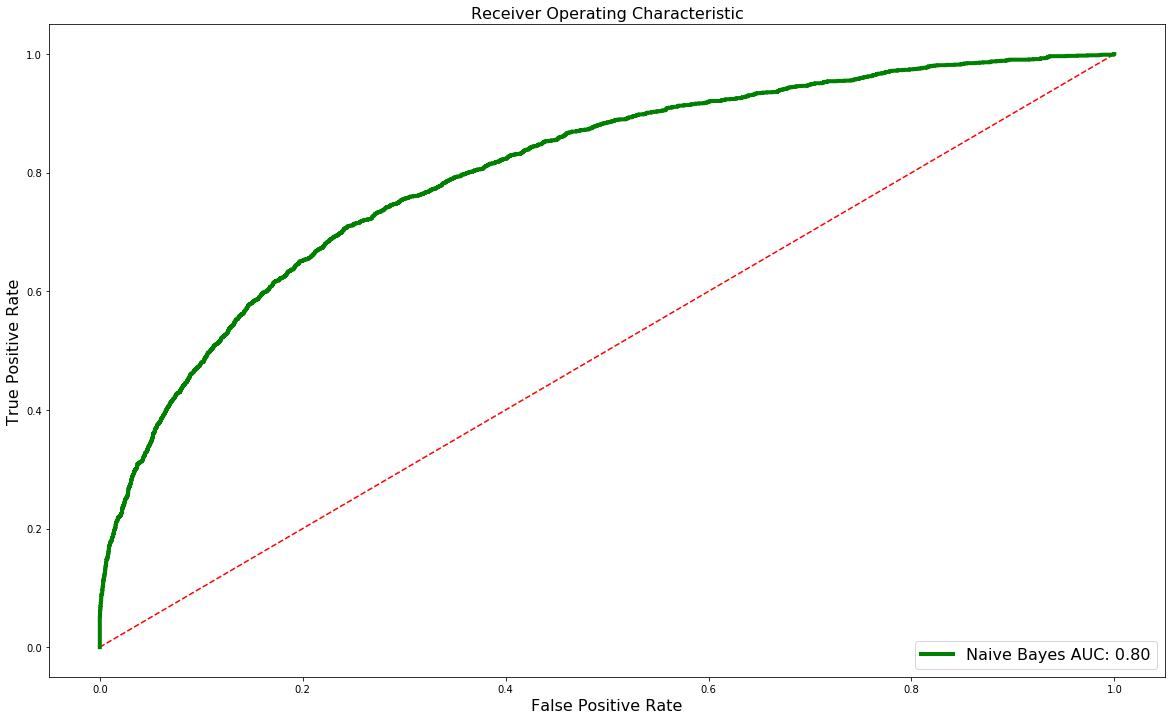

In [48]:
#code was just a copy paste from a web page
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 12))
plt.plot([0,1], [0,1], 'r--')

probs = gnb.predict_proba(X_esc)
probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y, probs)
roc_auc = auc(fpr, tpr)
label = 'Naive Bayes AUC:' + ' {0:.2f}'.format(roc_auc)
plt.plot(fpr, tpr, c = 'g', label = label, linewidth = 4)
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize = 16)
plt.title('Receiver Operating Characteristic', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

83.25969563082965


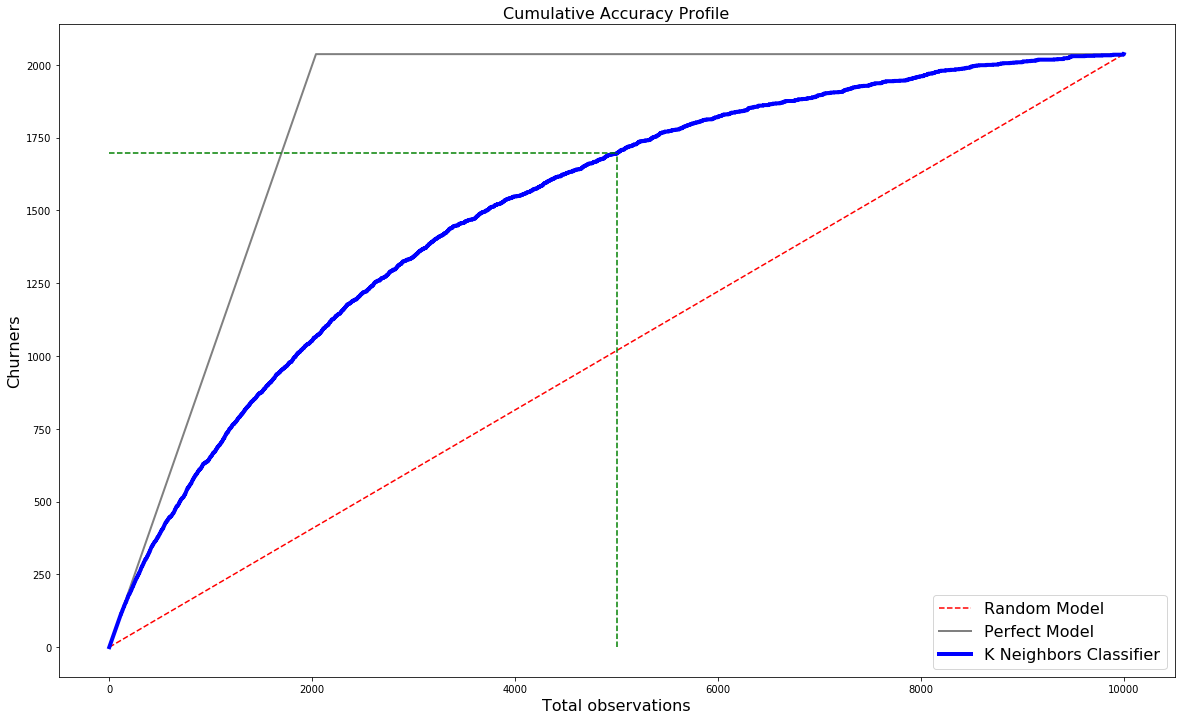

In [49]:
total = len(y)
class_1_count = np.sum(y)
class_0_count = total - class_1_count
plt.figure(figsize = (20, 12))
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')
probs = gnb.predict_proba(X_esc)
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, y), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'b', 
         label = 'K Neighbors Classifier', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 16)
plt.ylabel('Churners', fontsize = 16)
plt.title('Cumulative Accuracy Profile', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)
print(class_1_observed)

In [50]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])
# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a
# Area between Trained and Random Model
aR = auc(x_values, y_values) - a
print("Accuracy Rate for Naive Bayes: ", round(aR / aP, 4))

Accuracy Rate for Naive Bayes:  0.6068


# Reducing X to do Forest and GBC 

# Reduced Random Forest

In [15]:
forest_red = RandomForestClassifier(n_estimators=100, max_depth=10, max_leaf_nodes=64)
forest_red.fit(X, y)
cols1 = X.columns[forest_red.feature_importances_ > 0.1]
forest_red.fit(X_train[cols1], y_train)
print("Reduced Random Forest accuracy (training set):", 
      round(model_selection.cross_val_score(forest_red,X_train[cols1], y_train, scoring='accuracy',cv=50).mean(), 4))
print("Reduced Random Forest accuracy (test set):", 
      round(model_selection.cross_val_score(forest_red,X_test[cols1], y_test, scoring='accuracy',cv=50).mean(), 4))

Reduced Random Forest accuracy (training set): 0.841
Reduced Random Forest accuracy (test set): 0.834


In [16]:
forest_red.fit(X[cols1], y)
y_pred_cols = forest_red.predict(X[cols1])
conf8 = metrics.confusion_matrix(y, y_pred_cols)
print(conf8)
tp8 = conf8[1,1] / (conf8[1,1] + conf8[1,0])
fp8 = conf8[0,1] / (conf8[0,0] + conf8[0,1])
print('True positive rate (Reduced Random Forest):', round(tp8,4))
print('False positive rate (Reduced Random Forest):', round(fp8, 4))

[[7555  408]
 [1160  877]]
True positive rate (Reduced Random Forest): 0.4305
False positive rate (Reduced Random Forest): 0.0512


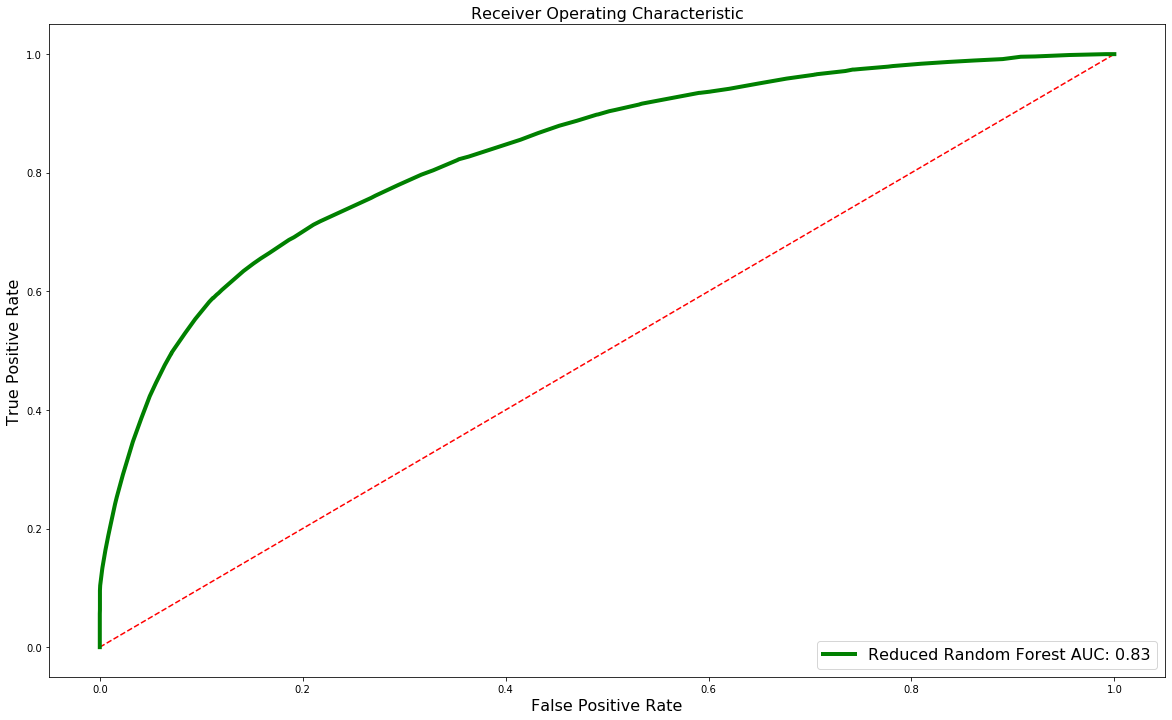

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 12))
plt.plot([0,1], [0,1], 'r--')

probs = forest_red.predict_proba(X[cols1])
probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y, probs)
roc_auc = auc(fpr, tpr)
label = 'Reduced Random Forest AUC:' + ' {0:.2f}'.format(roc_auc)
plt.plot(fpr, tpr, c = 'g', label = label, linewidth = 4)
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize = 16)
plt.title('Receiver Operating Characteristic', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

85.56701030927834


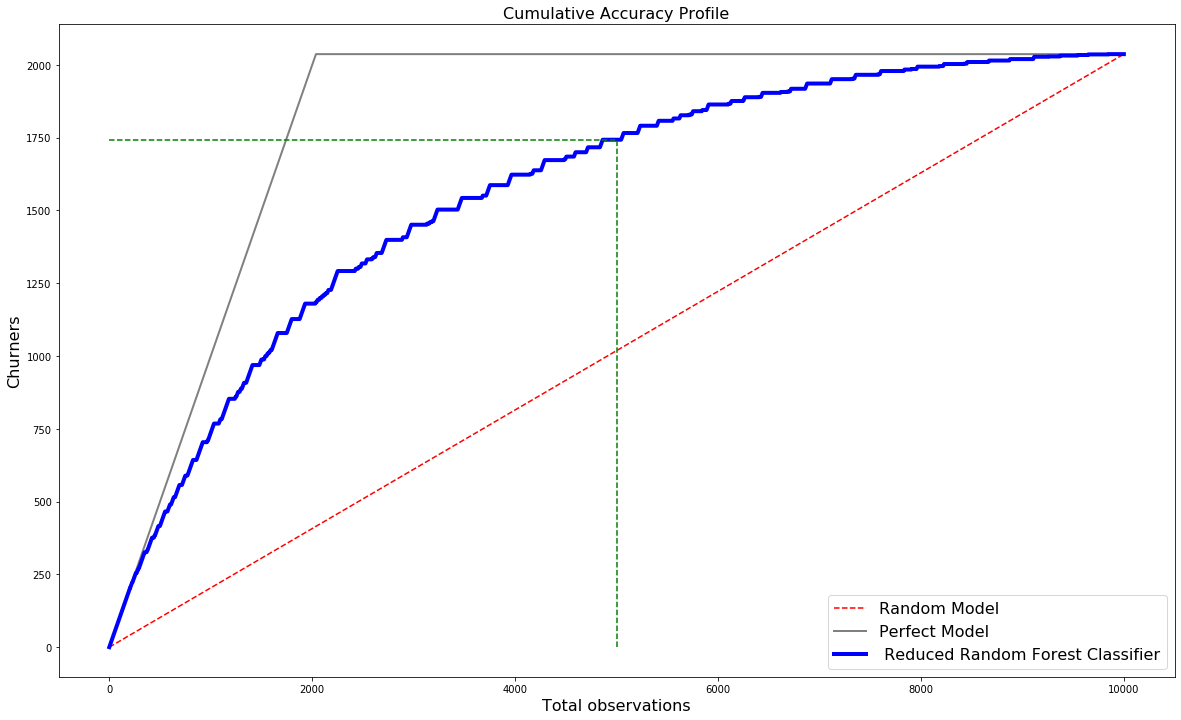

In [18]:
total = len(y)
class_1_count = np.sum(y)
class_0_count = total - class_1_count
plt.figure(figsize = (20, 12))
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')
probs = forest_red.predict_proba(X[cols1])
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, y), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'b', 
         label = ' Reduced Random Forest Classifier', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 16)
plt.ylabel('Churners', fontsize = 16)
plt.title('Cumulative Accuracy Profile', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)
print(class_1_observed)

In [19]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])
# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a
# Area between Trained and Random Model
aR = auc(x_values, y_values) - a
print("Accuracy Rate for Reduced Random Forest: ", round(aR / aP, 4))

Accuracy Rate for Reduced Random Forest:  0.6712


# GBC Reduced

In [20]:
from sklearn.ensemble import GradientBoostingClassifier
gbc_red = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=4)
gbc_red.fit(X, y)
cols2 = X.columns[gbc_red.feature_importances_ > 0.1]
gbc_red.fit(X_train[cols2], y_train)
print("Reduced Gradient Boosting Classifier accuracy (training set):", 
      round(model_selection.cross_val_score(gbc_red, X_train[cols2], y_train, scoring='accuracy',cv=50).mean(), 4))
print("Reduced Gradient Boosting Classifier accuracy (test set):", 
      round(model_selection.cross_val_score(gbc_red, X_test[cols2], y_test, scoring='accuracy',cv=50).mean(), 4))

Reduced Gradient Boosting Classifier accuracy (training set): 0.8546
Reduced Gradient Boosting Classifier accuracy (test set): 0.85


In [21]:
gbc_red.fit(X[cols2], y)
y_pred_gbc = gbc_red.predict(X[cols2])
conf9 = metrics.confusion_matrix(y, y_pred_gbc)
print(conf9)
tp9 = conf9[1,1] / (conf9[1,1] + conf9[1,0])
fp9 = conf9[0,1] / (conf9[0,0] + conf9[0,1])
print('True positive rate (Reduced Gradient Boosting Classifier):', round(tp9,4))
print('False positive rate (Reduced Gradient Boosting Classifier):', round(fp9, 4))

[[7741  222]
 [1192  845]]
True positive rate (Reduced Gradient Boosting Classifier): 0.4148
False positive rate (Reduced Gradient Boosting Classifier): 0.0279


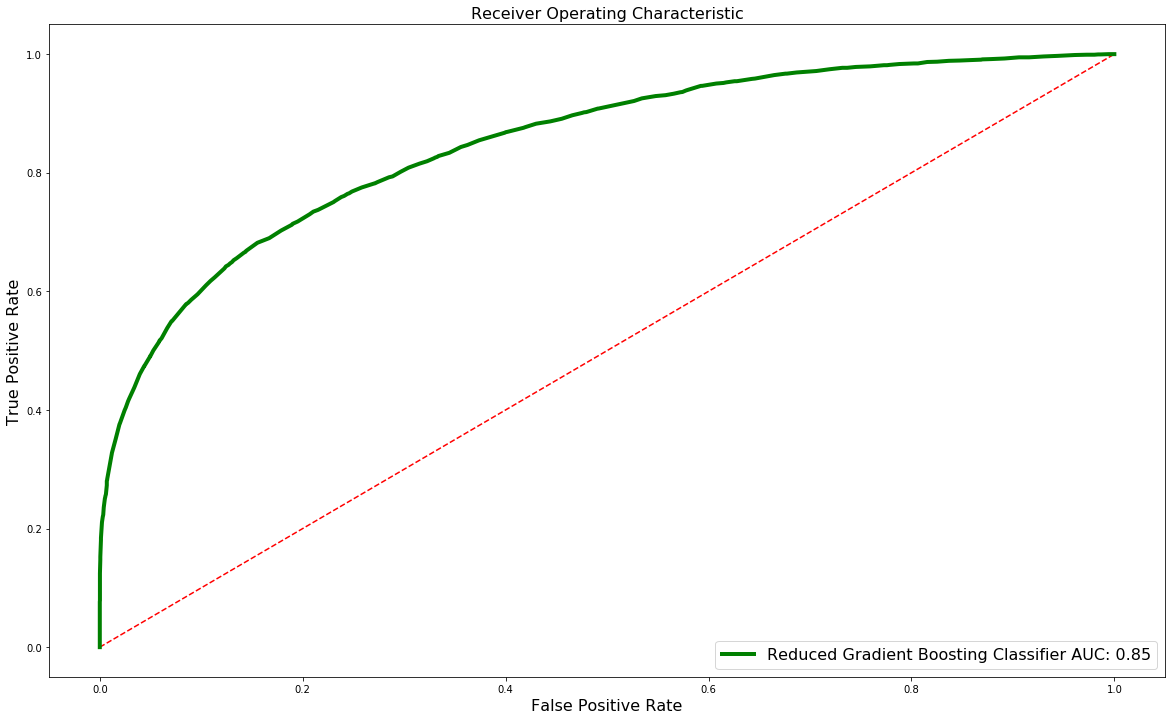

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 12))
plt.plot([0,1], [0,1], 'r--')

probs = gbc_red.predict_proba(X[cols2])
probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y, probs)
roc_auc = auc(fpr, tpr)
label = 'Reduced Gradient Boosting Classifier AUC:' + ' {0:.2f}'.format(roc_auc)
plt.plot(fpr, tpr, c = 'g', label = label, linewidth = 4)
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize = 16)
plt.title('Receiver Operating Characteristic', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

87.5306823760432


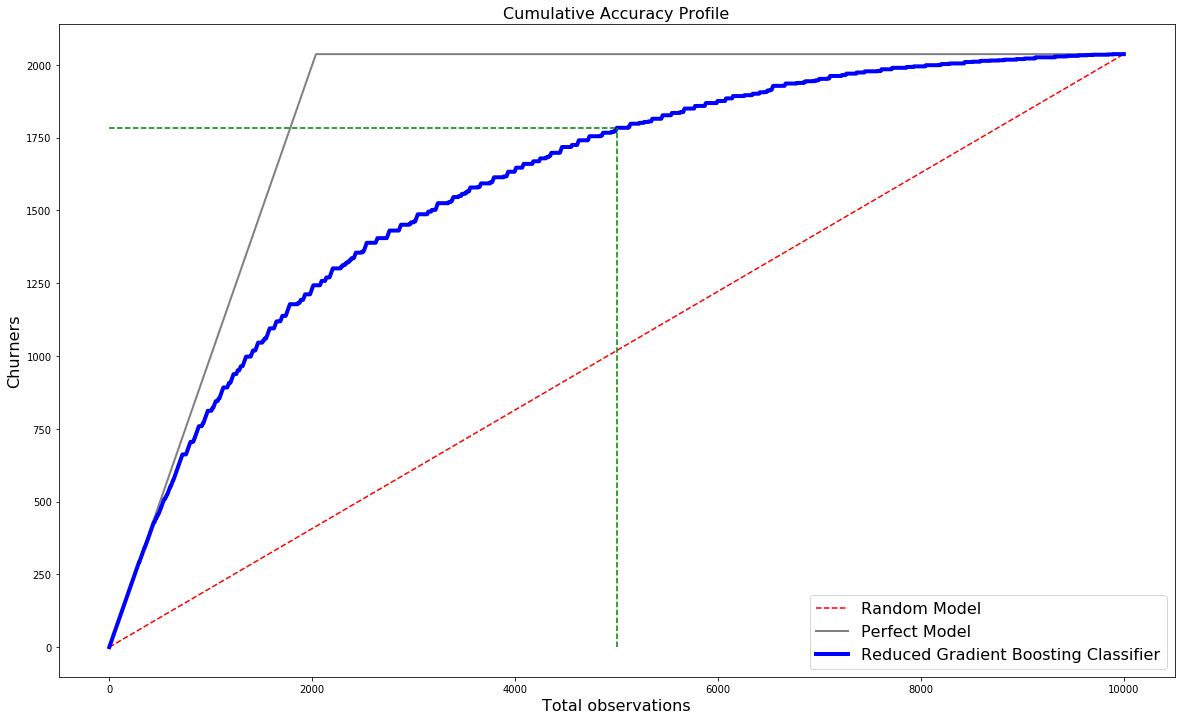

In [23]:
total = len(y)
class_1_count = np.sum(y)
class_0_count = total - class_1_count
plt.figure(figsize = (20, 12))
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')
probs = gbc_red.predict_proba(X[cols2])
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, y), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'b', 
         label = 'Reduced Gradient Boosting Classifier', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 16)
plt.ylabel('Churners', fontsize = 16)
plt.title('Cumulative Accuracy Profile', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)
print(class_1_observed)

In [24]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])
# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a
# Area between Trained and Random Model
aR = auc(x_values, y_values) - a
print("Accuracy Rate for Reduced GBC: ", round(aR / aP, 4))

Accuracy Rate for Reduced GBC:  0.7022


# K Means (just to see what we get)

In [61]:
#Its just a test to see what we get with K-Means. By clustering in 2 the algo does not recognize churners and no churners.
from sklearn.cluster import KMeans
#Use escalated variables because it is based on encleudiean distances. 
clus = KMeans(n_clusters=2)
clus.fit(X_esc)
y_pred_cluster = clus.predict(X_esc)
conf10 = metrics.confusion_matrix(y, y_pred_cluster)
print(conf9)
tp10 = conf10[1,1] / (conf10[1,1] + conf10[1,0])
fp10 = conf10[0,1] / (conf10[0,0] + conf10[0,1])
print('True positive rate (K Means):', round(tp10,4))
print('False positive rate (K Means):', round(fp10, 4))

[[7741  222]
 [1192  845]]
True positive rate (K Means): 0.3643
False positive rate (K Means): 0.4384
